In [2]:
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os
import shap

In [3]:
classes = {
    "Brain Cancer": {
        0: "Glioma", 1: "Meningioma", 2: "Pituitary Tumor"
    },
    "Breast Cancer": {
        0: "Benign", 1: "Malignant"
    },
    "Cervical Cancer": {
        0: "Dyskeratotic", 1: "Koilocytotic", 2: "Metaplastic", 3: "Parabasal", 4: "Superficial-Intermediat"
    },
    "Kidney Cancer": {
        0: "Normal", 1: "Tumor"
    },
    "Lung and Colon Cancer": {
        0: "Colon Adenocarcinoma", 1: "Colon Benign Tissue", 2: "Lung Adenocarcinoma", 3: "Lung Benign Tissue", 4: "Lung Squamous Cell Carcinoma"
    },
    "Lymphoma": {
        0: "Chronic Lymphocytic Leukemia", 1: "Follicular Lymphoma", 2: "Mantle Cell Lymphoma"
    },
    "Oral Cancer": {
        0: "Normal", 1: "Oral Squamous Cell Carcinoma"
    }
}

# **RESULT - GRADCAM AND SHAP**

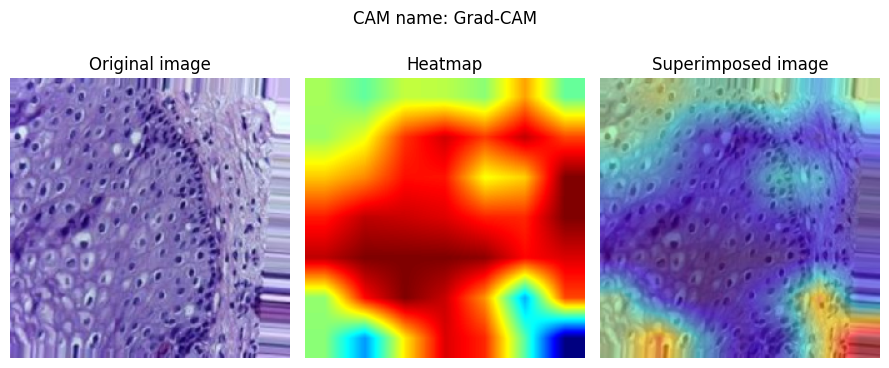

In [3]:
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.utils import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

def get_img_array(img_path, size=(224, 224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.uint8(array)
    #array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    # print(heatmap.shape)
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    # print(heatmap.shape)
    return pred_index.numpy(), heatmap.numpy()


def superimpose(img, cam):

    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * 0.5 + img * 0.5
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(
        np.uint8
    )
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return img, heatmap, superimposed_img
def plot_org_img_and_cam_heatmap(
    model,
    cam_func,
    superimpose,
#     cls_true,
#     class_to_label,
    cam_name,
    img,
):

    # for superimpose
    img = np.uint8(img)

    # cam / superimpose
    cls_pred, cam = cam_func(
        model=model,
        img_array=np.expand_dims(img, axis=0),
        last_conv_layer_name="top_conv",
    )
    img, heatmap, superimposed_img = superimpose(img, cam)

    fig, axs = plt.subplots(ncols=3, figsize=(9, 4))

    axs[0].imshow(img)
    axs[0].set_title("Original image")
    axs[0].axis("off")

    axs[1].imshow(heatmap)
    axs[1].set_title("Heatmap")
    axs[1].axis("off")

    axs[2].imshow(superimposed_img)
    axs[2].set_title("Superimposed image")
    axs[2].axis("off")

    title = (
        "CAM name: "
        + cam_name
#         + " / True label: "
#         + class_to_label[cls_true]
#         + " / Predicted label : "
#         + class_to_label[cls_pred]
    )
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
# class_dict = {
#     index: class_name for index, class_name in enumerate(class_names)
# }
# print(class_dict)
img_path = '/kaggle/input/test-data/test/Oral Cancer/oral_normal_1355.jpg'
model = load_model('/kaggle/input/efficient-net1/Efficient Net/Oral Cancer  - EfficientNetB0.keras', compile=False)
model.layers[-1].activation = None
plot_org_img_and_cam_heatmap(
    model=model,
    cam_func=make_gradcam_heatmap,
    superimpose=superimpose,
    #cls_true=np.argmax(valid_labels[4]),
#     class_to_label=class_dict,
    cam_name="Grad-CAM",
    img=get_img_array(img_path),
)

